In [13]:
import random
import statistics
from collections import defaultdict, deque
import threading
import numpy as np
import gymnasium as gym
import plotly.graph_objects as go
import ipywidgets as widgets

In [14]:
# Defining the constants for Q-learning
ALPHA = 0.15
GAMMA = 0.95
EPSILON = 0.2

In [15]:
# Number of bins for discretizing the continuous state space
N_BINS_X = 30
N_BINS_X_DOT = 30
N_BINS_THETA = 30
N_BINS_THETA_DOT = 30

In [16]:
# Boundaries for the state variables in the CartPole environment
x_low, x_high = -2.4, 2.4
x_dot_low, x_dot_high = -4, 4
theta_low, theta_high = -0.209439, 0.209439
theta_dot_low, theta_dot_high = -4, 4
# Create bins for discretization of the state space
bins_x = np.linspace(x_low, x_high, num=N_BINS_X)
bins_x_dot = np.linspace(x_dot_low, x_dot_high, num=N_BINS_X_DOT)
bins_theta = np.linspace(theta_low, theta_high, num=N_BINS_THETA)
bins_theta_dot = np.linspace(theta_dot_low, theta_dot_high, num=N_BINS_THETA_DOT)
BINS = [bins_x, bins_x_dot, bins_theta, bins_theta_dot]
bins_x

array([-2.4       , -2.23448276, -2.06896552, -1.90344828, -1.73793103,
       -1.57241379, -1.40689655, -1.24137931, -1.07586207, -0.91034483,
       -0.74482759, -0.57931034, -0.4137931 , -0.24827586, -0.08275862,
        0.08275862,  0.24827586,  0.4137931 ,  0.57931034,  0.74482759,
        0.91034483,  1.07586207,  1.24137931,  1.40689655,  1.57241379,
        1.73793103,  1.90344828,  2.06896552,  2.23448276,  2.4       ])

In [17]:
def get_state_from_observation(observation): # Function to convert continuous state variables into discrete states using digitization
    return tuple([np.digitize(var, bins) for var, bins in zip(observation, BINS)])

get_state_from_observation([1.2, 2, 0.045, 4])

(22, 22, 18, 30)

In [18]:
def policy(env, i_state, Q, episode): # Epsilon-greedy policy for action selection
    if np.random.uniform(0,1) < EPSILON:
        action = env.action_space.sample()
    else:
        if len(Q[i_state].items()) == 0:
            action = env.action_space.sample()
        else:
            action, _ = max(Q[i_state].items(), key=lambda x: x[1])
    return action

In [19]:
def update_q(Q, i_state, i_next_state, action, reward): # Q-learning update rule
    max_q_value = max(Q[i_next_state].values(), default=0) # Max Q-value for next state
    TD = reward + GAMMA * max_q_value - Q[i_state][action] # Temporal difference error
    Q[i_state][action] += ALPHA * TD # Update Q-table

In [20]:
def dashboard(training, step_log=1000): # Dashboard to display training progress
    h_rewards = deque(maxlen=step_log) # Store rewards for averaging

    dashboard.STOP_TRAINING = False # Stop training flag and button
    bt_stop = widgets.Button(description='Stop Training', button_style='danger')
    def f_stop(bt_stop):
        dashboard.STOP_TRAINING = True
    bt_stop.on_click(f_stop)

    # Set up a Plotly figure for displaying rewards during training
    fig = go.FigureWidget()
    fig.add_scatter(x=[], y=[], mode='markers+lines')
    fig.layout.yaxis.rangemode = 'tozero'
    fig.layout.title = 'Dashboard for training RL agents'
    fig.layout.xaxis.title = 'Episode'
    fig.layout.yaxis.title = 'Reward'

    def update_sc_reward(episode, reward): # Function to update the reward plot
        with fig.batch_update():
            fig.data[0].x += (episode,)
            fig.data[0].y += (reward,)
    
    def sim(*args, **kwargs): # Simulate training and update dashboard
        display(bt_stop) 
        display(fig)
        for episode, reward in training(*args, **kwargs):
            h_rewards.append(reward)
            if episode % step_log == 0: # Update reward plot every 'step_log' episodes
                update_sc_reward(episode, np.mean(h_rewards))
            if dashboard.STOP_TRAINING: # Stop training if the button is clicked
                break
        bt_stop.disabled = True # Disable stop button after training ends
    
    def thread(*args, **kwargs): # Start training in a separate thread
        t = threading.Thread(target=sim, args=args, kwargs=kwargs)
        t.start()
        return t
    return thread

# Training function for the Q-learning agent
@dashboard
def train_q_agent(Q, n_episodes):
    with gym.make('CartPole-v1') as env:
        for episode in range(n_episodes):
            observation, _ = env.reset() # Reset the environment and get initial state
            i_state = get_state_from_observation(observation) # Convert state to discrete form
            episode_reward = 0
            terminated = truncated = False
            while not (terminated or truncated): # Continue until episode ends
                action = policy(env, i_state, Q, episode) # Select action based on policy
                observation, reward, terminated, truncated, _ = env.step(action)
                i_next_state = get_state_from_observation(observation)
                episode_reward += reward
                update_q(Q, i_state, i_next_state, action, reward) # Update Q-table
                i_state = i_next_state
            yield episode, episode_reward # Yield current episode number and total reward

# Initialize Q-table (state-action values) as a defaultdict of defaultdicts
Q = defaultdict(lambda: defaultdict(int))
# Start training the Q-learning agent
train_q_agent(Q, n_episodes=1_000_000)

Button(button_style='danger', description='Stop Training', style=ButtonStyle())

<Thread(Thread-6 (sim), started 1564)>

FigureWidget({
    'data': [{'mode': 'markers+lines',
              'type': 'scatter',
              'uid': 'b8ab4b1e-d4f4-4a96-a6d0-2ecd8cb9f919',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Dashboard for training RL agents'},
               'xaxis': {'title': {'text': 'Episode'}},
               'yaxis': {'rangemode': 'tozero', 'title': {'text': 'Reward'}}}
})

In [21]:
from IPython.display import display, clear_output
from PIL import Image
import time

def visualise_q_agent(Q, n_episodes=1): # Visualization function for the trained Q-learning agent
    with gym.make('CartPole-v1', render_mode='rgb_array') as env:
        for episode in range(n_episodes):
            state, _ = env.reset()
            i_state = get_state_from_observation(state)
            terminated = truncated = False
            frames = []  # Store frames

            while not (terminated or truncated):
                if len(Q[i_state].items()) == 0:
                    action = env.action_space.sample()
                else:
                    action, _ = max(Q[i_state].items(), key=lambda x: x[1])
                
                state, _, terminated, truncated, _ = env.step(action)
                i_state = get_state_from_observation(state)
                
                frame = env.render()
                frames.append(frame)  # Collect frames

            # Display the frames using PIL
            for frame in frames:
                clear_output(wait=True)
                img = Image.fromarray(frame)  # Convert numpy array to image
                display(img)
                time.sleep(0.05)  # Adjust speed of animation

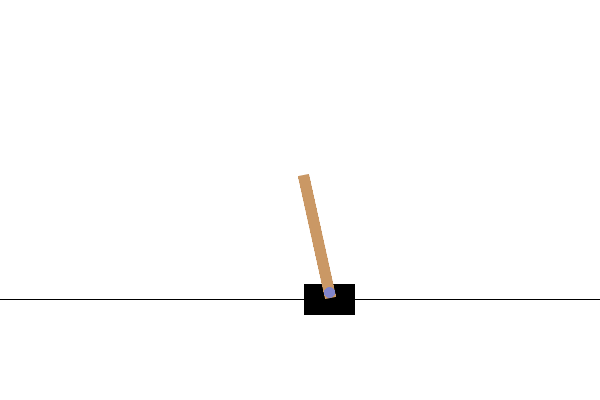

In [22]:
visualise_q_agent(Q, 1)